In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Sample Comments.xlsx")

print("Shape : ", df.shape)
df.head()

Shape :  (100, 2)


,Sr. No,Employee Comments
0,1,The last 12 months have been extremely challen...
1,2,"All agreed, no further comments required"
2,3,Work is completed to best of my ability and wh...
3,4,I have had a very good 12 months. Although cha...
4,5,I feel I work to a good standard and in a prof...


In [3]:
print("Number of NA Values :", df.isna().sum().sum())
print("Number of Duplicate Values :", df.duplicated().sum())

Number of NA Values : 0
Number of Duplicate Values : 0


### Word Count

count    100.000000
mean      70.590000
std       50.278637
min        6.000000
25%       28.500000
50%       58.000000
75%      106.750000
max      171.000000
Name: Words, dtype: float64


<AxesSubplot: >

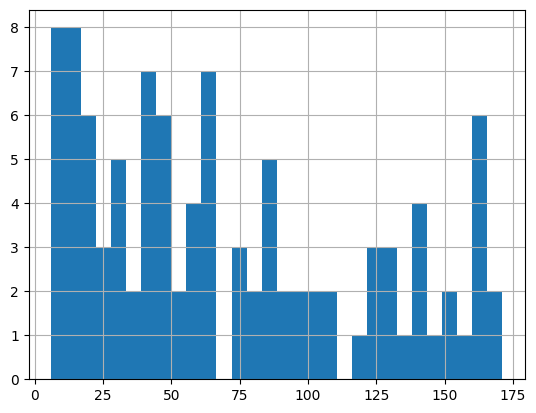

In [4]:
df["Words"] = df["Employee Comments"].apply(lambda x : len(x.split()))

print(df["Words"].describe())

df["Words"].hist(bins=30)

* Average words in comment: 70
* Maximum words in comment: 171
* Minimum words in comment: 6
* Distribution is right skewed, which means most of the comments are short.

### Word Cloud

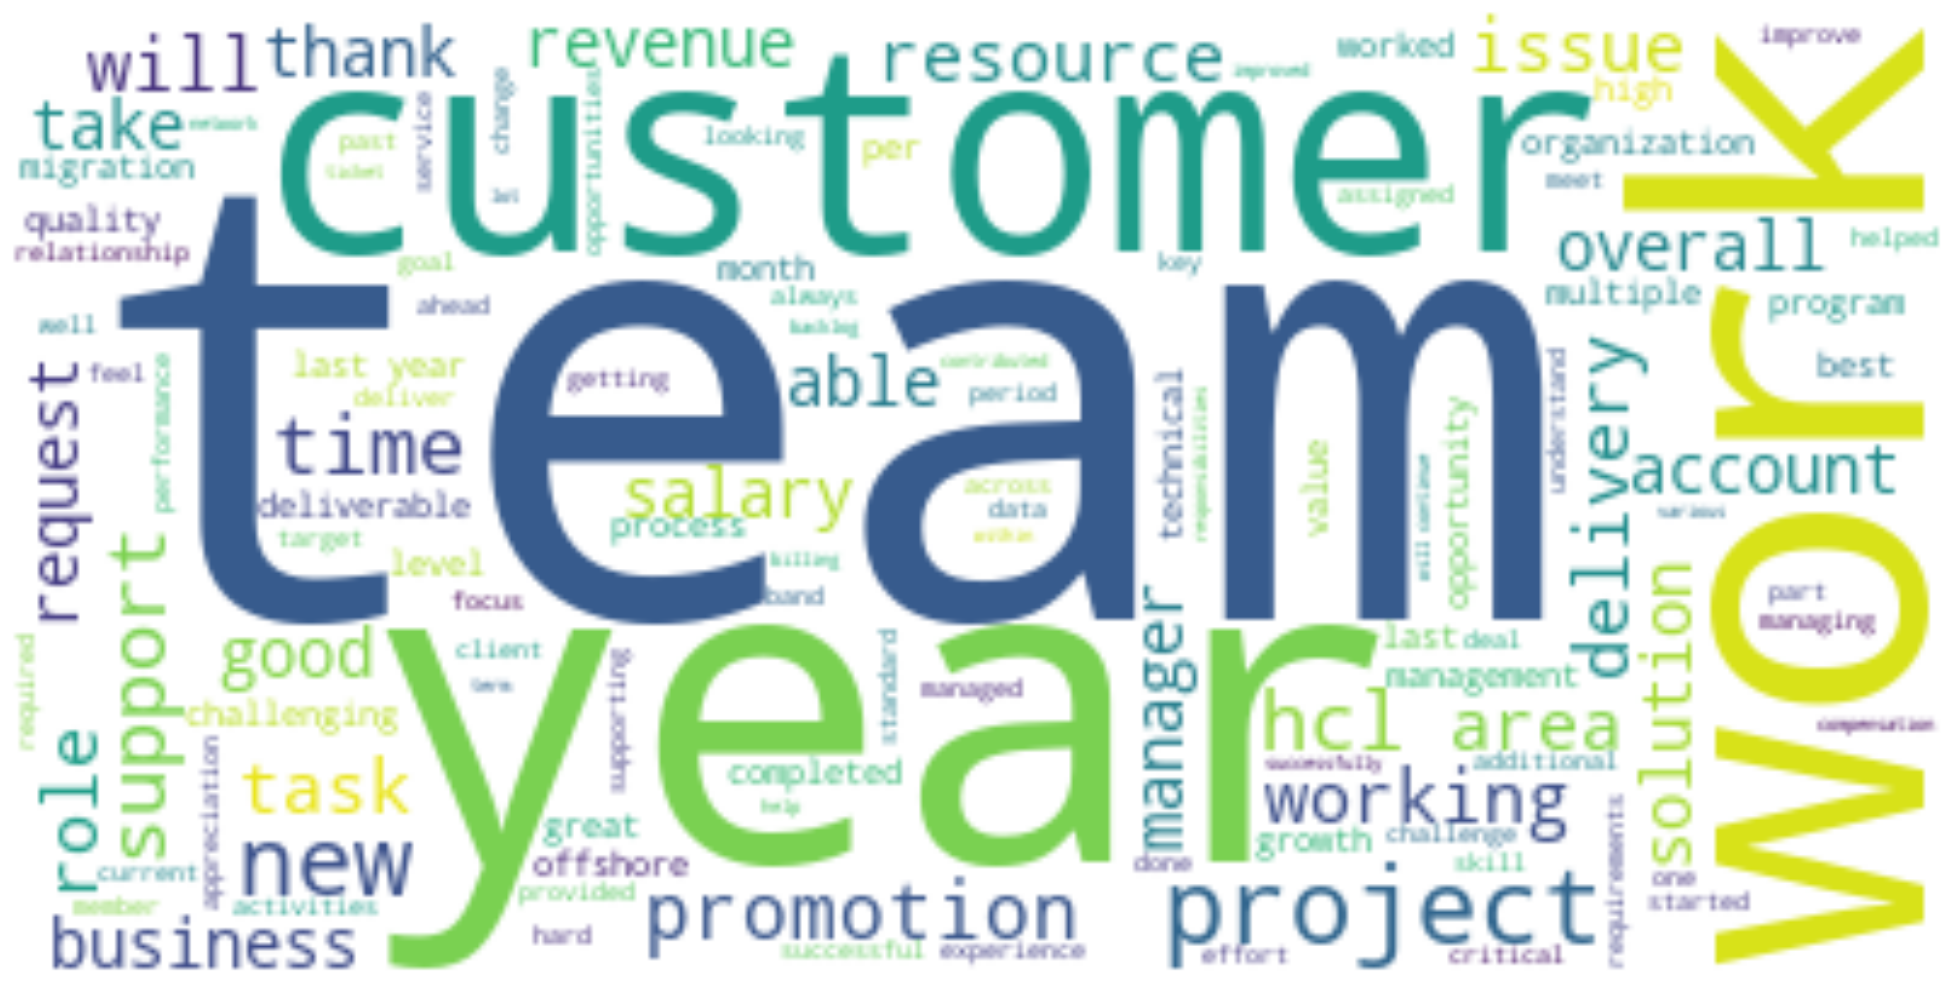

In [5]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

df["lower"] = df["Employee Comments"].apply(lambda x : x.lower())
final_text = " ".join(df["lower"])

stopwords = set(STOPWORDS)

word_cloud = WordCloud(stopwords=stopwords, background_color="white").generate(final_text)

plt.figure(figsize = (25,25))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* The most commonly occurring words are: team, year, customer, work, project.

### Sentiment Analysis

* The data doesn't contain any labels.
* It's better to use state-of-the-art pretrained models for classification.
* Based on the word cloud above, I thought of using the FinBERT Model [ProsusAI/finbert](https://huggingface.co/ProsusAI/finbert) for sentiment classification.


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

df_list = list(df["lower"]) 

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

inputs = tokenizer(df_list, padding = True, truncation = True, return_tensors='pt')
outputs = model(**inputs)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
model.config.id2label

positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Sentiment':df_list, "Positive":positive, "Negative":negative, "Neutral":neutral}  

df_sentiment = pd.DataFrame(table, columns = ["Sentiment", "Positive", "Negative", "Neutral"])

df_sentiment.to_csv("Sentiment.csv")

In [7]:
df_sentiment = pd.read_csv("Sentiment.csv")

df_sentiment.drop(["Unnamed: 0"], axis=1, inplace=True)

d = {0 :"Positive", 1:"Negative", 2:"Neutral"}
df_sentiment["Label"] = [d[i] for i in df_sentiment.iloc[:, 1:].values.argmax(axis=1)]

df_sentiment.head()

,Sentiment,Positive,Negative,Neutral,Label
0,the last 12 months have been extremely challen...,0.014927,0.925434,0.059639,Negative
1,"all agreed, no further comments required",0.037846,0.026759,0.935395,Neutral
2,work is completed to best of my ability and wh...,0.140959,0.012023,0.847018,Neutral
3,i have had a very good 12 months. although cha...,0.808823,0.011780,0.179396,Positive
4,i feel i work to a good standard and in a prof...,0.161567,0.014022,0.824411,Neutral


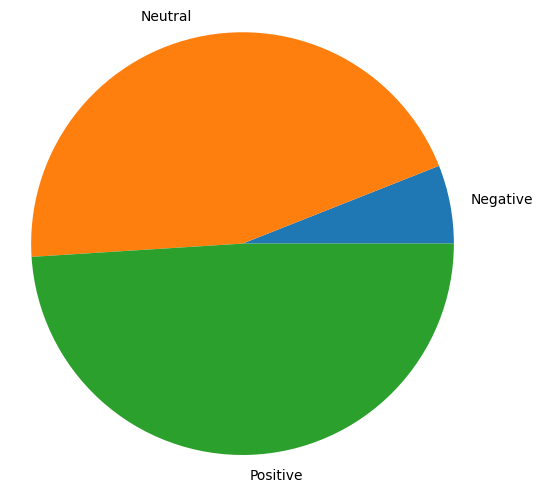

In [8]:
from collections import Counter

word_counts = Counter(df_sentiment["Label"])

words = list(word_counts.keys())
frequencies = list(word_counts.values())

plt.figure(figsize=(6, 6))
plt.pie(frequencies, labels=words,)
plt.axis('equal')

plt.show()

* Most of the comments have positive and neutral sentiment.
* Only 6 percent of the comments have negative sentiment.

### Future Work 

* Classify comments based upon the department.
* Extract information from the negative sentiment comments to work on those areas.
* Extract information from positive sentiment comments to maintain standards.
* Extract information => Keyword Extraction